In [64]:
from pixiedust import packageManager
jarLocation="graphframes:graphframes:0.5.0-spark2.1-s_2.11"
packageManager.installPackage(jarLocation)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Package graphframes:graphframes:0.5.0-spark2.1-s_2.11 downloaded successfully
Please restart Kernel to complete installation of the new package
Successfully added package graphframes:graphframes:0.5.0-spark2.1-s_2.11


In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.5.0-spark2.1-s_2.11 pyspark-shell'


In [2]:
from pyspark.sql import SparkSession

# Inititating Spark Application according to the recommended way
spark = SparkSession \
    .builder \
    .appName("BSGApp") \
    .config("spark.driver.memory","2g")\
    .config("spark.executor.memory","8g")\
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

print("Spark version "+str(sc.version))

print("Spark Application ID "+sc.applicationId)

print("app name "+sc.appName)

print("env "+sc.master)

print("Web UI "+sc.uiWebUrl)

Spark version 2.2.0
Spark Application ID local-1516707629761
app name BSGApp
env local[*]
Web UI http://192.168.1.60:4040


In [3]:
flight_DF=spark.read.option("header", "true").csv("Monthly_Data/*.csv", inferSchema='true').drop("_c50")
flight_DF.cache()

DataFrame[FL_DATE: timestamp, UNIQUE_CARRIER: string, AIRLINE_ID: int, CARRIER: string, TAIL_NUM: string, FL_NUM: int, ORIGIN_AIRPORT_ID: int, ORIGIN_AIRPORT_SEQ_ID: int, ORIGIN_CITY_MARKET_ID: int, ORIGIN: string, ORIGIN_CITY_NAME: string, ORIGIN_STATE_ABR: string, ORIGIN_STATE_FIPS: int, ORIGIN_STATE_NM: string, ORIGIN_WAC: int, DEST_AIRPORT_ID: int, DEST_AIRPORT_SEQ_ID: int, DEST_CITY_MARKET_ID: int, DEST: string, DEST_CITY_NAME: string, DEST_STATE_ABR: string, DEST_STATE_FIPS: int, DEST_STATE_NM: string, DEST_WAC: int, CRS_DEP_TIME: int, DEP_TIME: int, DEP_DELAY: double, DEP_DELAY_NEW: double, DEP_DEL15: double, DEP_DELAY_GROUP: int, DEP_TIME_BLK: string, TAXI_OUT: double, WHEELS_OFF: int, WHEELS_ON: int, TAXI_IN: double, CRS_ARR_TIME: int, ARR_TIME: int, ARR_DELAY: double, ARR_DELAY_NEW: double, ARR_DEL15: double, ARR_DELAY_GROUP: int, ARR_TIME_BLK: string, CANCELLED: double, DIVERTED: double, CRS_ELAPSED_TIME: double, ACTUAL_ELAPSED_TIME: double, AIR_TIME: double, FLIGHTS: double

In [4]:
from pixiedust import display

Pixiedust database opened successfully


In [221]:
display(flight_DF)

FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP
2014-11-01 00:00:00,B6,20409,B6,N568JB,703,12478,1247802,31703,JFK,"New York, NY",NY,36,New York,22,14843,1484304,34819,SJU,"San Juan, PR",PR,72,Puerto Rico,3,1437,1442,5.0,5.0,0.0,0,1400-1459,23.0,1505,1841,6.0,1824,1847,23.0,23.0,1.0,1,1800-1859,0.0,0.0,227.0,245.0,216.0,1.0,1598.0,7
2014-11-01 00:00:00,B6,20409,B6,N569JB,745,12478,1247802,31703,JFK,"New York, NY",NY,36,New York,22,14254,1425403,34254,PSE,"Ponce, PR",PR,72,Puerto Rico,3,2359,9,10.0,10.0,0.0,0,2300-2359,13.0,22,403,4.0,348,407,19.0,19.0,1.0,1,0001-0559,0.0,0.0,229.0,238.0,221.0,1.0,1617.0,7
2014-11-01 00:00:00,EV,20366,EV,N905EV,2502,14457,1445702,34457,RAP,"Rapid City, SD",SD,46,South Dakota,67,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,720,714,-6.0,0.0,0.0,-1,0700-0759,10.0,724,1016,12.0,1040,1028,-12.0,0.0,0.0,-1,1000-1059,0.0,0.0,140.0,134.0,112.0,1.0,835.0,4
2014-11-01 00:00:00,EV,20366,EV,N906EV,2504,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,13290,1329002,33290,MHK,"Manhattan/Ft. Riley, KS",KS,20,Kansas,62,1520,1541,21.0,21.0,1.0,1,1500-1559,10.0,1551,1656,2.0,1640,1658,18.0,18.0,1.0,1,1600-1659,0.0,0.0,80.0,77.0,65.0,1.0,431.0,2
2014-11-01 00:00:00,EV,20366,EV,N906EV,2504,13290,1329002,33290,MHK,"Manhattan/Ft. Riley, KS",KS,20,Kansas,62,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,1705,1711,6.0,6.0,0.0,0,1700-1759,8.0,1719,1821,7.0,1825,1828,3.0,3.0,0.0,0,1800-1859,0.0,0.0,80.0,77.0,62.0,1.0,431.0,2
2014-11-01 00:00:00,EV,20366,EV,N905EV,2506,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,12891,1289102,32891,LAW,"Lawton/Fort Sill, OK",OK,40,Oklahoma,73,1055,1100,5.0,5.0,0.0,0,1000-1059,10.0,1110,1141,2.0,1140,1143,3.0,3.0,0.0,0,1100-1159,0.0,0.0,45.0,43.0,31.0,1.0,140.0,1
2014-11-01 00:00:00,EV,20366,EV,N905EV,2506,12891,1289102,32891,LAW,"Lawton/Fort Sill, OK",OK,40,Oklahoma,73,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,1205,1204,-1.0,0.0,0.0,-1,1200-1259,10.0,1214,1242,8.0,1250,1250,0.0,0.0,0.0,0,1200-1259,0.0,0.0,45.0,46.0,28.0,1.0,140.0,1
2014-11-01 00:00:00,EV,20366,EV,N908EV,2533,10781,1078102,30781,BTR,"Baton Rouge, LA",LA,22,Louisiana,72,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,1400,1505,65.0,65.0,1.0,4,1400-1459,6.0,1511,1615,6.0,1525,1621,56.0,56.0,1.0,3,1500-1559,0.0,0.0,85.0,76.0,64.0,1.0,383.0,2
2014-11-01 00:00:00,EV,20366,EV,N908EV,2533,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,10781,1078102,30781,BTR,"Baton Rouge, LA",LA,22,Louisiana,72,1215,1325,70.0,70.0,1.0,4,1200-1259,14.0,1339,1431,7.0,1335,1438,63.0,63.0,1.0,4,1300-1359,0.0,0.0,80.0,73.0,52.0,1.0,383.0,2
2014-11-01 00:00:00,EV,20366,EV,N879AS,2535,15412,1541202,35412,TYS,"Knoxville, TN",TN,47,Tennessee,54,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,600,553,-7.0,0.0,0.0,-1,0600-0659,14.0,607,657,11.0,715,708,-7.0,0.0,0.0,-1,0700-0759,0.0,0.0,135.0,135.0,110.0,1.0,772.0,4


In [123]:
import optimus as op

# Instance of profiler class
profiler = op.DataFrameProfiler(flight_DF)
profiler.profiler()

Deleting previous folder if exists...
Creation of checkpoint directory...
Done.


/home/anil/.local/lib/python3.5/site-packages/spark_df_profiling_optimus/base.py:321: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if isinstance(stats["max"], pd.tslib.Timestamp):


Number of variables,50
Number of observations,5819811
Total Missing (%),0.3%
Total size in memory,0.0 B
Average record size in memory,0.0 B
Numeric,21
Categorical,13
Date,1
Text (Unique),0
Rejected,15
Correlation,0.99052


In [5]:
flight_DF.filter(flight_DF["FLIGHTS"]>1).count()

0

In [124]:
flight_DF.filter((flight_DF["CANCELLED"]!=1)).count()

5692827

In [31]:
flight_DF.filter((flight_DF["CANCELLED"]!=1) & (flight_DF["DIVERTED"]!=1)).filter(flight_DF["AIR_TIME"].isNull()).count()

0

In [5]:
flight_DF.filter(flight_DF["Diverted"]==1).filter(flight_DF["AIR_TIME"].isNotNull()).count()

0

In [222]:
display(flight_DF.filter(flight_DF["Diverted"]==1))

FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP
2014-11-01 00:00:00,EV,20366,EV,N11106,6170,10158,1015804,30158,ACY,"Atlantic City, NJ",NJ,34,New Jersey,21,12266,1226603,31453,IAH,"Houston, TX",TX,48,Texas,74,730,723,-7.0,0.0,0.0,-1,0700-0759,9.0,732,1057,8.0,1019,1105,None,None,None,None,1000-1059,0.0,1.0,229.0,None,None,1.0,1345.0,6
2014-11-01 00:00:00,FL,20437,FL,N950AT,93,10397,1039705,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,14122,1412202,30198,PIT,"Pittsburgh, PA",PA,42,Pennsylvania,23,840,839,-1.0,0.0,0.0,-1,0800-0859,15.0,854,1309,3.0,1030,1312,None,None,None,None,1000-1059,0.0,1.0,110.0,None,None,1.0,526.0,3
2014-11-01 00:00:00,OO,20304,OO,N632SK,4853,14869,1486903,34614,SLC,"Salt Lake City, UT",UT,49,Utah,87,15041,1504102,35041,SUN,"Sun Valley/Hailey/Ketchum, ID",ID,16,Idaho,83,1700,1650,-10.0,0.0,0.0,-1,1700-1759,14.0,1704,None,None,1810,None,None,None,None,None,1800-1859,0.0,1.0,70.0,None,None,1.0,222.0,1
2014-11-01 00:00:00,OO,20304,OO,N930SW,5349,13930,1393003,30977,ORD,"Chicago, IL",IL,17,Illinois,41,11337,1133703,31337,DLH,"Duluth, MN",MN,27,Minnesota,63,845,852,7.0,7.0,0.0,0,0800-0859,17.0,909,1223,4.0,1019,1227,None,None,None,None,1000-1059,0.0,1.0,94.0,None,None,1.0,397.0,2
2014-11-01 00:00:00,OO,20304,OO,N930SW,5475,13342,1334205,33342,MKE,"Milwaukee, WI",WI,55,Wisconsin,45,11292,1129202,30325,DEN,"Denver, CO",CO,8,Colorado,82,1518,2010,292.0,292.0,1.0,12,1500-1559,16.0,2026,2324,7.0,1706,2331,None,None,None,None,1700-1759,0.0,1.0,168.0,None,None,1.0,896.0,4
2014-11-01 00:00:00,VX,21171,VX,N628VA,187,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,14771,1477101,32457,SFO,"San Francisco, CA",CA,6,California,91,1030,1035,5.0,5.0,0.0,0,1000-1059,10.0,1045,1533,5.0,1355,1538,None,None,None,None,1300-1359,0.0,1.0,385.0,None,None,1.0,2565.0,11
2014-11-01 00:00:00,WN,19393,WN,N952WN,4276,14893,1489302,33192,SMF,"Sacramento, CA",CA,6,California,91,13891,1389101,32575,ONT,"Ontario, CA",CA,6,California,91,1645,1644,-1.0,0.0,0.0,-1,1600-1659,9.0,1653,2000,3.0,1800,2003,None,None,None,None,1800-1859,0.0,1.0,75.0,None,None,1.0,390.0,2
2014-11-01 00:00:00,AA,19805,AA,N3DCAA,196,13303,1330303,32467,MIA,"Miami, FL",FL,12,Florida,33,14100,1410002,34100,PHL,"Philadelphia, PA",PA,42,Pennsylvania,23,600,622,22.0,22.0,1.0,1,0600-0659,18.0,640,1126,12.0,845,1138,None,None,None,None,0800-0859,0.0,1.0,165.0,None,None,1.0,1013.0,5
2014-11-01 00:00:00,AA,19805,AA,N3AYAA,1294,13303,1330303,32467,MIA,"Miami, FL",FL,12,Florida,33,12266,1226603,31453,IAH,"Houston, TX",TX,48,Texas,74,1405,1406,1.0,1.0,0.0,0,1400-1459,19.0,1425,1853,6.0,1554,1859,None,None,None,None,1500-1559,0.0,1.0,169.0,None,None,1.0,964.0,4
2014-11-01 00:00:00,DL,19790,DL,N968DL,1696,10529,1052904,30529,BDL,"Hartford, CT",CT,9,Connecticut,11,10397,1039705,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,1242,1237,-5.0,0.0,0.0,-1,1200-1259,15.0,1252,1636,9.0,1513,1645,None,None,None,None,1500-1559,0.0,1.0,151.0,None,None,1.0,859.0,4


## 1. What is the 15th most flown route? 

In [125]:
top15Routes=flight_DF\
.filter((flight_DF["CANCELLED"]!=1) & (flight_DF["DIVERTED"]!=1))\
.groupBy(["ORIGIN","ORIGIN_CITY_NAME","DEST","DEST_CITY_NAME"])\
.count()\
.orderBy("count", ascending=False)\
.limit(15)

top15Routes.cache()
display(top15Routes)

ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,count
SFO,"San Francisco, CA",LAX,"Los Angeles, CA",12973
LAX,"Los Angeles, CA",SFO,"San Francisco, CA",12958
JFK,"New York, NY",LAX,"Los Angeles, CA",12391
LAX,"Los Angeles, CA",JFK,"New York, NY",12344
LAS,"Las Vegas, NV",LAX,"Los Angeles, CA",11658
LAX,"Los Angeles, CA",LAS,"Las Vegas, NV",11357
HNL,"Honolulu, HI",OGG,"Kahului, HI",9699
OGG,"Kahului, HI",HNL,"Honolulu, HI",9634
JFK,"New York, NY",SFO,"San Francisco, CA",8790
SFO,"San Francisco, CA",JFK,"New York, NY",8783



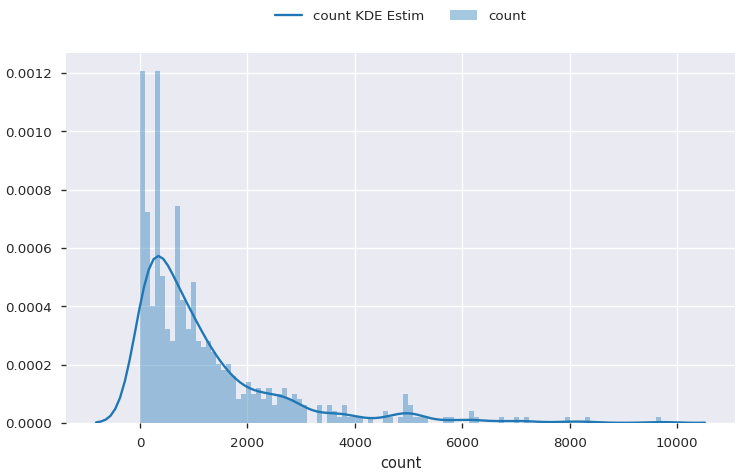

In [236]:
display(top15Routes)

In [237]:
top15Routes.toPandas().to_excel("outputs/q1.xlsx")

## Loading Lookup Datasets

In [8]:
airportDF=spark.read.option("header", "true").csv("Lookup_Tables/L_AIRPORT_ID.csv", inferSchema='true')
airportDF.cache()
display(airportDF)

Code,Description
10001,"Afognak Lake, AK: Afognak Lake Airport"
10003,"Granite Mountain, AK: Bear Creek Mining Strip"
10004,"Lik, AK: Lik Mining Camp"
10005,"Little Squaw, AK: Little Squaw Airport"
10006,"Kizhuyak, AK: Kizhuyak Bay"
10007,"Klawock, AK: Klawock Seaplane Base"
10008,"Elizabeth Island, AK: Elizabeth Island Airport"
10009,"Homer, AK: Augustin Island"
10010,"Hudson, NY: Columbia County"
10011,"Peach Springs, AZ: Grand Canyon West"


In [9]:
from pyspark.sql.functions import collect_list,concat_ws
carrierDF=spark.read.option("header", "true").csv("Lookup_Tables/L_CARRIER_HISTORY.csv", inferSchema='true')

uniqueCarrierDF=carrierDF.groupBy("Code").agg(concat_ws("--", collect_list("Description")).alias("CARRIER_NAME"))
uniqueCarrierDF.cache()

display(uniqueCarrierDF)

Code,CARRIER_NAME
CLQ,Aero Transcolombiana (1993 - 2000)
KKQ,Transmeridian Air Cargo Ltd. (1981 - 1989)
LT,Luftransport-Unternehmen (1981 - 2009)
MM,Euro Atlantic Airways (2004 - 2009)--Sociedad Aeronautica De Med (1981 - 1989)
PEA,Pearson Aircraft (1960 - 2002)
SKJ,Sky-Jet (1993 - 2002)
WNG,Wings Airways (1960 - 2002)
XBV,Nal Inc. (1981 - 1989)
0YQ,Comlux Malta Ltd. (2009 - )
AAT,Air Sunshine Inc. (1983 - )


## 2. What carrier has flown the 3rd most number of flights? How many? 

In [245]:
top3FlightsCarrier=flight_DF\
.filter((flight_DF["CANCELLED"]!=1))\
.groupBy("UNIQUE_CARRIER").count()\
.orderBy("count", ascending=False)\
.join(uniqueCarrierDF,flight_DF["UNIQUE_CARRIER"]==uniqueCarrierDF["Code"])\
.drop("Code")\
.limit(3)

top3FlightsCarrier.cache()

display(top3FlightsCarrier)

UNIQUE_CARRIER,count,CARRIER_NAME
WN,1159468,Southwest Airlines Co. (1979 - )
DL,793873,Delta Air Lines Inc. (1960 - )
EV,651893,ExpressJet Airlines Inc. (2012 - )--Atlantic Southeast Airlines (1993 - 2011)


In [244]:
top3FlightsCarrier.toPandas().to_excel("outputs/q2.xlsx")

## 3. What airport has the 10th most delays? 

In [136]:
from pyspark.sql.functions import sum,col

originDF=flight_DF.groupBy(["ORIGIN_AIRPORT_ID"]).agg(sum(col("DEP_DELAY_NEW")).alias("TOTAL_DEP_DELAY"))
destinationDF=flight_DF.groupBy(["DEST_AIRPORT_ID"]).agg(sum(col("ARR_DELAY_NEW")).alias("TOTAL_ARR_DELAY"))

joinedDF=originDF.join(destinationDF,originDF["ORIGIN_AIRPORT_ID"]==destinationDF["DEST_AIRPORT_ID"])\
        .withColumn("TOTAL_DELAY",col("TOTAL_DEP_DELAY")+col("TOTAL_ARR_DELAY"))\
        .withColumnRenamed("ORIGIN_AIRPORT_ID","AIRPORT_ID")\
        .drop("DEST_AIRPORT_ID")\
        .orderBy(["TOTAL_DELAY"],ascending=False)
        
top10DelayAirports=joinedDF.join(airportDF,joinedDF["AIRPORT_ID"]==airportDF["Code"])\
        .withColumnRenamed("Description","AIRPORT_NAME")\
        .drop("Code")\
        .limit(10)

In [137]:
display(top10DelayAirports)

AIRPORT_ID,TOTAL_DEP_DELAY,TOTAL_ARR_DELAY,TOTAL_DELAY,AIRPORT_NAME
13930,5099505.0,5403345.0,10502850.0,"Chicago, IL: Chicago O'Hare International"
10397,4129125.0,4195308.0,8324433.0,"Atlanta, GA: Hartsfield-Jackson Atlanta International"
11298,3900128.0,4237688.0,8137816.0,"Dallas/Fort Worth, TX: Dallas/Fort Worth International"
11292,3542548.0,3109325.0,6651873.0,"Denver, CO: Denver International"
14771,2507469.0,3127287.0,5634756.0,"San Francisco, CA: San Francisco International"
12892,2692831.0,2852542.0,5545373.0,"Los Angeles, CA: Los Angeles International"
12266,2393722.0,2368760.0,4762482.0,"Houston, TX: George Bush Intercontinental/Houston"
11618,1817894.0,1957536.0,3775430.0,"Newark, NJ: Newark Liberty International"
12889,1935766.0,1656182.0,3591948.0,"Las Vegas, NV: McCarran International"
14107,1867638.0,1664589.0,3532227.0,"Phoenix, AZ: Phoenix Sky Harbor International"


In [121]:
top10DelayAirports.toPandas().to_excel("outputs/q3.xlsx")

## 4. What is the second most popular day of the week to travel? Why? 

In [5]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
import datetime

def getDayOfWeekFunc(date):
    return date.strftime('%A')

getDayOfWeek=udf(lambda date: getDayOfWeekFunc(date),StringType())

In [178]:
from pyspark.sql.types import DateType
flown_flight_DF=flight_DF\
.filter((flight_DF["CANCELLED"]!=1))\
.withColumn("FLIGHT_DAY_OF_WEEK",getDayOfWeek(flight_DF["FL_DATE"]))
flight_DF.cache()

DataFrame[FL_DATE: timestamp, UNIQUE_CARRIER: string, AIRLINE_ID: int, CARRIER: string, TAIL_NUM: string, FL_NUM: int, ORIGIN_AIRPORT_ID: int, ORIGIN_AIRPORT_SEQ_ID: int, ORIGIN_CITY_MARKET_ID: int, ORIGIN: string, ORIGIN_CITY_NAME: string, ORIGIN_STATE_ABR: string, ORIGIN_STATE_FIPS: int, ORIGIN_STATE_NM: string, ORIGIN_WAC: int, DEST_AIRPORT_ID: int, DEST_AIRPORT_SEQ_ID: int, DEST_CITY_MARKET_ID: int, DEST: string, DEST_CITY_NAME: string, DEST_STATE_ABR: string, DEST_STATE_FIPS: int, DEST_STATE_NM: string, DEST_WAC: int, CRS_DEP_TIME: int, DEP_TIME: int, DEP_DELAY: double, DEP_DELAY_NEW: double, DEP_DEL15: double, DEP_DELAY_GROUP: int, DEP_TIME_BLK: string, TAXI_OUT: double, WHEELS_OFF: int, WHEELS_ON: int, TAXI_IN: double, CRS_ARR_TIME: int, ARR_TIME: int, ARR_DELAY: double, ARR_DELAY_NEW: double, ARR_DEL15: double, ARR_DELAY_GROUP: int, ARR_TIME_BLK: string, CANCELLED: double, DIVERTED: double, CRS_ELAPSED_TIME: double, ACTUAL_ELAPSED_TIME: double, AIR_TIME: double, FLIGHTS: double

In [248]:
noOfFlightsPerDay=flown_flight_DF.groupBy(["FLIGHT_DAY_OF_WEEK"]).count().orderBy(["count"],ascending=False)

display(noOfFlightsPerDay)

FLIGHT_DAY_OF_WEEK,count
Monday,846865
Friday,846047
Wednesday,842260
Thursday,840667
Tuesday,822188
Sunday,804549
Saturday,690251


In [250]:
noOfFlightsPerDay.toPandas().to_excel("outputs/q4.xlsx")

### 4.1 Why Friday is the 2nd Most Active Day?

In [179]:
from pyspark.sql.functions import concat_ws,countDistinct
flown_flight_DF.withColumn("ROUTE",concat_ws("->","ORIGIN","DEST")).groupBy("FLIGHT_DAY_OF_WEEK").agg(countDistinct("ROUTE").alias("DIFFERENT_ROUTES_AVAILABLE")).orderBy("DIFFERENT_ROUTES_AVAILABLE",ascending=False).show()

+------------------+--------------------------+
|FLIGHT_DAY_OF_WEEK|DIFFERENT_ROUTES_AVAILABLE|
+------------------+--------------------------+
|            Sunday|                      4499|
|          Saturday|                      4463|
|            Friday|                      4431|
|            Monday|                      4411|
|          Thursday|                      4399|
|         Wednesday|                      4398|
|           Tuesday|                      4393|
+------------------+--------------------------+



In [180]:
from pyspark.sql.functions import avg,col

flown_flight_DF.groupBy("FLIGHT_DAY_OF_WEEK").agg(avg(col("DEP_DELAY_NEW")+col("ARR_DELAY_NEW")).alias("AVERAGE_DELAY")).orderBy("AVERAGE_DELAY",ascending=False).show()

+------------------+------------------+
|FLIGHT_DAY_OF_WEEK|     AVERAGE_DELAY|
+------------------+------------------+
|          Thursday|29.796882473695575|
|            Friday|28.746224817801917|
|            Monday|28.292352289197716|
|         Wednesday| 26.89374577529823|
|           Tuesday|25.926181863418275|
|            Sunday|24.687216941579855|
|          Saturday|22.717203896690368|
+------------------+------------------+



In [181]:
from pyspark.sql.functions import avg,col

flown_flight_DF.groupBy("FLIGHT_DAY_OF_WEEK").agg(avg(col("DISTANCE")).alias("AVERAGE_DISTANCE")).orderBy("AVERAGE_DISTANCE",ascending=False).show()

+------------------+-----------------+
|FLIGHT_DAY_OF_WEEK| AVERAGE_DISTANCE|
+------------------+-----------------+
|          Saturday|833.6178593004573|
|            Sunday|809.9595040202647|
|            Friday|798.7522052557364|
|          Thursday|798.4571964880267|
|            Monday| 798.198959692513|
|         Wednesday| 795.031429724788|
|           Tuesday| 792.117696925764|
+------------------+-----------------+



## Q4- May Be The reason is roundtrips in a week??

In [20]:
from pyspark.sql.functions import lit,col,dayofyear

#Create Vertices (airports) and Edges (flights)
tripVertices = airportDF.withColumnRenamed("code","id")
tripEdges = flown_flight_DF.select(col("ORIGIN_AIRPORT_ID").alias("src"),
                             col("DEST_AIRPORT_ID").alias("dst"),
                             lit("follow").alias("relationship"),
                             col("FLIGHT_DAY_OF_WEEK"),
                            dayofyear(col("FL_DATE")).alias("DAY_OF_YEAR")
                            )

In [21]:
from graphframes import *

g = GraphFrame(tripVertices, tripEdges)

In [23]:
motifs=g.find("(a)-[e]->(b); (b)-[e2]->(a)")\
.filter("e.DAY_OF_YEAR < e2.DAY_OF_YEAR")\
.filter((col("e2.DAY_OF_YEAR")-col("e.DAY_OF_YEAR"))<7)\
.filter("e.FLIGHT_DAY_OF_WEEK != e2.FLIGHT_DAY_OF_WEEK")

motifs.cache()
motifs.show()

+--------------------+--------------------+--------------------+--------------------+
|                   a|                   e|                   b|                  e2|
+--------------------+--------------------+--------------------+--------------------+
|[12323,Wilmington...|[12323,10397,foll...|[10397,Atlanta, G...|[10397,12323,foll...|
|[12323,Wilmington...|[12323,10397,foll...|[10397,Atlanta, G...|[10397,12323,foll...|
|[12323,Wilmington...|[12323,10397,foll...|[10397,Atlanta, G...|[10397,12323,foll...|
|[12323,Wilmington...|[12323,10397,foll...|[10397,Atlanta, G...|[10397,12323,foll...|
|[12323,Wilmington...|[12323,10397,foll...|[10397,Atlanta, G...|[10397,12323,foll...|
|[12323,Wilmington...|[12323,10397,foll...|[10397,Atlanta, G...|[10397,12323,foll...|
|[12323,Wilmington...|[12323,10397,foll...|[10397,Atlanta, G...|[10397,12323,foll...|
|[12323,Wilmington...|[12323,10397,foll...|[10397,Atlanta, G...|[10397,12323,foll...|
|[12323,Wilmington...|[12323,10397,foll...|[10397,Atla

## Q4- Answer to Why

In [29]:
rountripDayCounts=motifs.groupBy(["e.FLIGHT_DAY_OF_WEEK","e2.FLIGHT_DAY_OF_WEEK"]).count().orderBy(["count"],ascending=False).toPandas()
rountripDayCounts

,FLIGHT_DAY_OF_WEEK,FLIGHT_DAY_OF_WEEK,count
0,Friday,Monday,7245294
1,Thursday,Friday,7221481
2,Thursday,Monday,7202836
3,Monday,Friday,7125431
4,Wednesday,Monday,7099052
5,Monday,Wednesday,7098485
6,Wednesday,Friday,7091737
7,Monday,Thursday,7082531
8,Wednesday,Thursday,7079724
9,Monday,Tuesday,7074676


In [66]:
import networkx as nx
DG=nx.DiGraph()
DG.add_weighted_edges_from(rountripDayCounts.values)

In [118]:
import pandas as pd
centralities=nx.eigenvector_centrality(DG)
centralities

{'Friday': 0.3908879117224543,
 'Monday': 0.38886989262914856,
 'Saturday': 0.3307483952082671,
 'Sunday': 0.3733618581494972,
 'Thursday': 0.39060970352036145,
 'Tuesday': 0.3806350786081502,
 'Wednesday': 0.38695512074511523}

In [42]:
rountripDayCounts.to_excel("outputs/q4_why.xlsx")

In [97]:
pd.DataFrame(centralities,index=centralities.keys()).T.ix[:,1].to_excel("outputs/q4_why_2.xlsx")

/home/anil/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


## 5. What other actionable insights can we gain by leveraging the TranStats dataset? 

In [6]:
from pyspark.sql.functions import month,when,col,lit,weekofyear
flight_DF=flight_DF.withColumn("MONTH_OF_FLIGHT",month(flight_DF["FL_DATE"]))\
            .withColumn("WEEK_OF_FLIGHT",weekofyear(flight_DF["FL_DATE"]))\
          .withColumn("FINAL_STATUS",
                     when(col("CANCELLED")==1,lit("CANCELLED"))
                     .when(col("DIVERTED")==1,lit("DIVERTED"))
                     .otherwise(lit("ACCOMPLISHED"))
                    )
flight_DF.cache()

DataFrame[FL_DATE: timestamp, UNIQUE_CARRIER: string, AIRLINE_ID: int, CARRIER: string, TAIL_NUM: string, FL_NUM: int, ORIGIN_AIRPORT_ID: int, ORIGIN_AIRPORT_SEQ_ID: int, ORIGIN_CITY_MARKET_ID: int, ORIGIN: string, ORIGIN_CITY_NAME: string, ORIGIN_STATE_ABR: string, ORIGIN_STATE_FIPS: int, ORIGIN_STATE_NM: string, ORIGIN_WAC: int, DEST_AIRPORT_ID: int, DEST_AIRPORT_SEQ_ID: int, DEST_CITY_MARKET_ID: int, DEST: string, DEST_CITY_NAME: string, DEST_STATE_ABR: string, DEST_STATE_FIPS: int, DEST_STATE_NM: string, DEST_WAC: int, CRS_DEP_TIME: int, DEP_TIME: int, DEP_DELAY: double, DEP_DELAY_NEW: double, DEP_DEL15: double, DEP_DELAY_GROUP: int, DEP_TIME_BLK: string, TAXI_OUT: double, WHEELS_OFF: int, WHEELS_ON: int, TAXI_IN: double, CRS_ARR_TIME: int, ARR_TIME: int, ARR_DELAY: double, ARR_DELAY_NEW: double, ARR_DEL15: double, ARR_DELAY_GROUP: int, ARR_TIME_BLK: string, CANCELLED: double, DIVERTED: double, CRS_ELAPSED_TIME: double, ACTUAL_ELAPSED_TIME: double, AIR_TIME: double, FLIGHTS: double


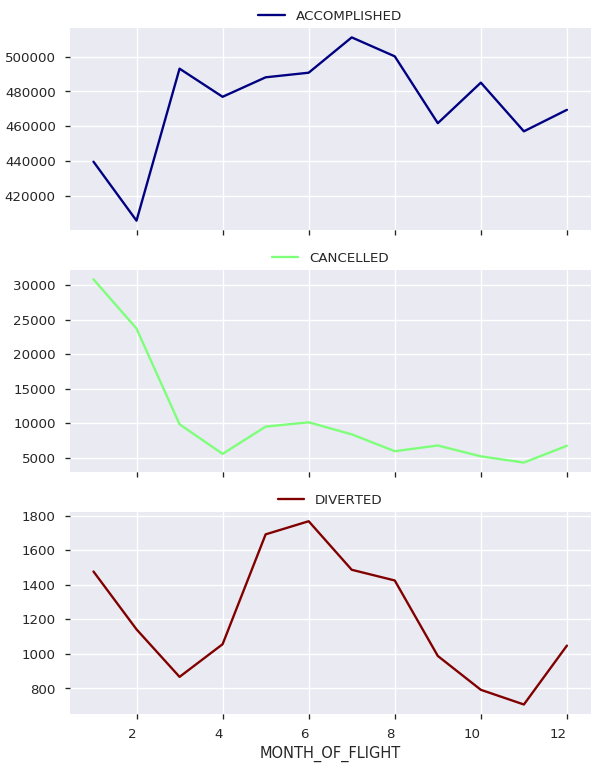

In [252]:
from pixiedust import display
display(flight_DF)

In [168]:
display(flight_DF)


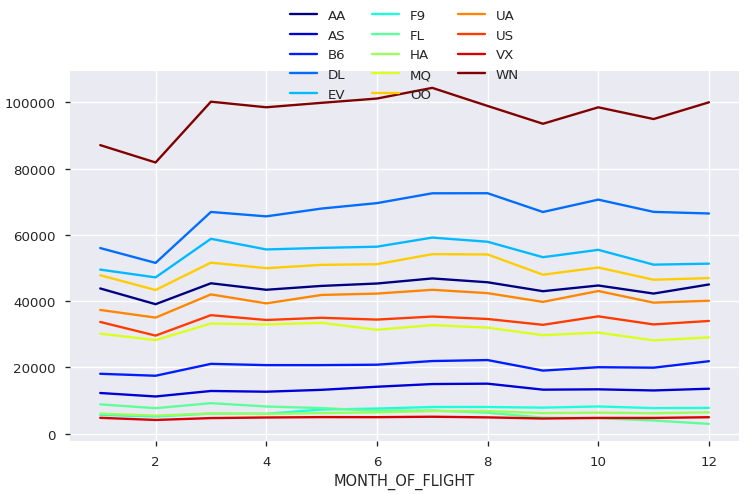

In [257]:
display(flight_DF.filter((flight_DF["FINAL_STATUS"]=="ACCOMPLISHED") | (flight_DF["FINAL_STATUS"]=="DIVERTED")))


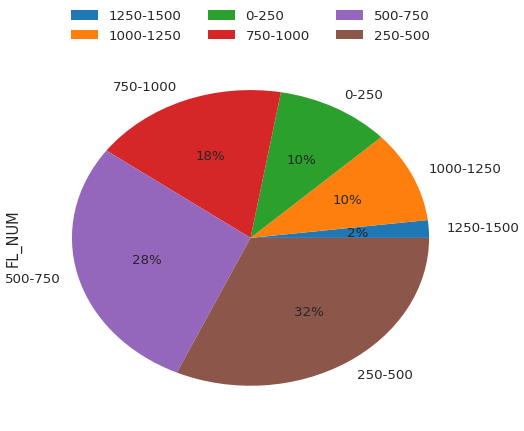

In [159]:
from pyspark.sql.functions import concat_ws
display(flight_DF.withColumn("ROUTE_DISTANCE_INTERVAL",concat_ws("-",(col("DISTANCE_GROUP")-lit(1))*lit(250),col("DISTANCE_GROUP")*lit(250)))\
        .filter((flight_DF["FINAL_STATUS"]=="ACCOMPLISHED") | (flight_DF["FINAL_STATUS"]=="DIVERTED")).filter(flight_DF["UNIQUE_CARRIER"]=="EV"))


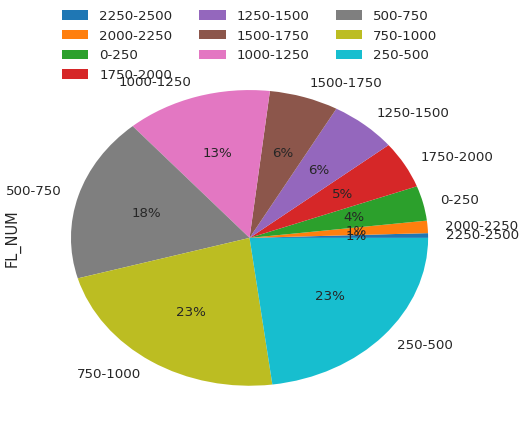

In [161]:
display(flight_DF.withColumn("ROUTE_DISTANCE_INTERVAL",concat_ws("-",(col("DISTANCE_GROUP")-lit(1))*lit(250),col("DISTANCE_GROUP")*lit(250)))\
.filter((flight_DF["FINAL_STATUS"]=="ACCOMPLISHED") | (flight_DF["FINAL_STATUS"]=="DIVERTED")).filter(flight_DF["UNIQUE_CARRIER"]=="WN"))

In [129]:
weeklyCount=flight_DF\
.filter((flight_DF["FINAL_STATUS"]=="ACCOMPLISHED") | (flight_DF["FINAL_STATUS"]=="DIVERTED"))\
.groupBy(["FINAL_STATUS","FL_DATE"]).count()\
.withColumnRenamed("FL_DATE","ds")\
.withColumnRenamed("count","y")\
.orderBy(["FINAL_STATUS","FL_DATE"],ascending=True)\
.toPandas()
weeklyCount

,FINAL_STATUS,ds,y
0,ACCOMPLISHED,2014-01-01,13428
1,ACCOMPLISHED,2014-01-02,14605
2,ACCOMPLISHED,2014-01-03,14203
3,ACCOMPLISHED,2014-01-04,13272
4,ACCOMPLISHED,2014-01-05,13274
5,ACCOMPLISHED,2014-01-06,13327
6,ACCOMPLISHED,2014-01-07,13024
7,ACCOMPLISHED,2014-01-08,14725
8,ACCOMPLISHED,2014-01-09,15505
9,ACCOMPLISHED,2014-01-10,15542


In [130]:
accomplishedFlights=weeklyCount.drop("FINAL_STATUS", axis=1)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/anil/.local/lib/python3.5/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/home/anil/.local/lib/python3.5/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


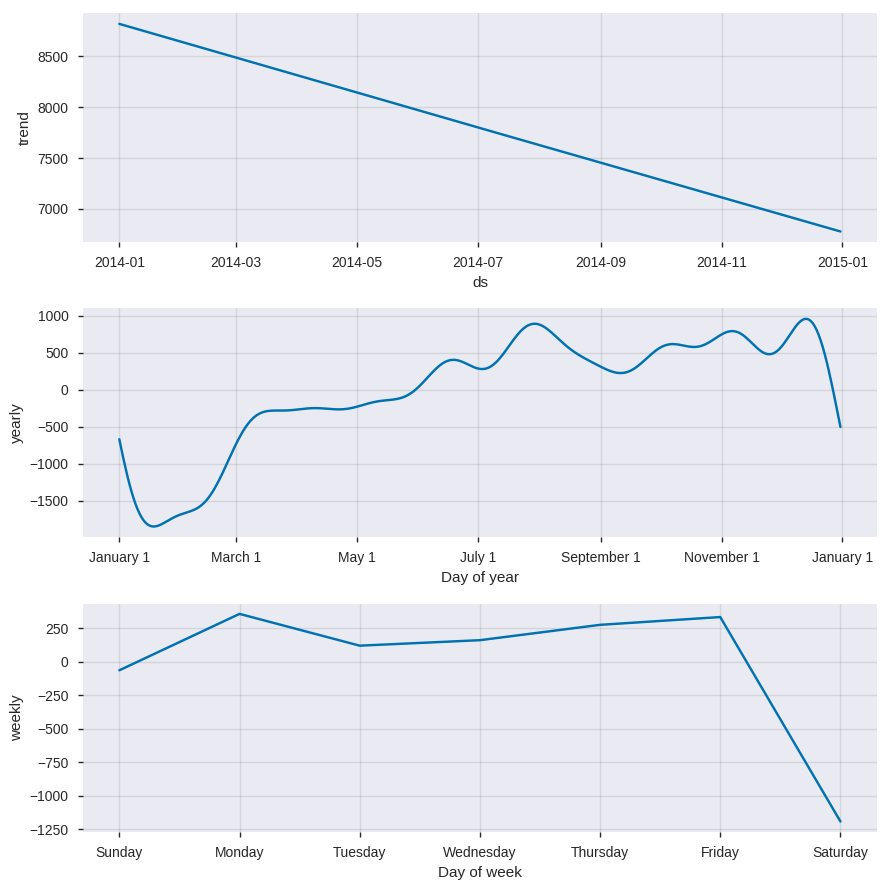

In [131]:
from fbprophet import Prophet
m = Prophet(yearly_seasonality=True)
m.fit(accomplishedFlights);
forecast = m.predict(accomplishedFlights)
m.plot_components(forecast);

In [132]:
seasonlityDF=spark.createDataFrame(forecast)\
.withColumn("daily_seasonality_ratio",col("seasonal")/col("yhat"))\
.select(col("ds").alias("FL_DATE"),col("daily_seasonality_ratio"))

seasonlityDF.cache()

DataFrame[FL_DATE: timestamp, daily_seasonality_ratio: double]

In [141]:
seasonlityDF.withColumn("trend",(lit(1)+col("daily_seasonality_ratio"))).show()

+-------------------+-----------------------+------------------+
|            FL_DATE|daily_seasonality_ratio|             trend|
+-------------------+-----------------------+------------------+
|2014-01-01 00:00:00|   -0.05660485665263756|0.9433951433473624|
|2014-01-01 00:00:00|   -0.05660485665263756|0.9433951433473624|
|2014-01-02 00:00:00|   -0.05863522649783...|0.9413647735021605|
|2014-01-02 00:00:00|   -0.05863522649783...|0.9413647735021605|
|2014-01-03 00:00:00|   -0.06744158357177854|0.9325584164282215|
|2014-01-03 00:00:00|   -0.06744158357177854|0.9325584164282215|
|2014-01-04 00:00:00|   -0.33410156883654957|0.6658984311634504|
|2014-01-04 00:00:00|   -0.33410156883654957|0.6658984311634504|
|2014-01-05 00:00:00|   -0.15651498667108327|0.8434850133289167|
|2014-01-05 00:00:00|   -0.15651498667108327|0.8434850133289167|
|2014-01-06 00:00:00|   -0.11083319848071287|0.8891668015192872|
|2014-01-06 00:00:00|   -0.11083319848071287|0.8891668015192872|
|2014-01-07 00:00:00|   -

In [166]:
from pyspark.sql.functions import count,sum,col,round,avg,lit,lag

monthlyFlightsTrendPerCarrier=flight_DF.filter((col("FINAL_STATUS")=="ACCOMPLISHED") | (col("FINAL_STATUS")=="DIVERTED"))\
        .groupBy(["FL_DATE","UNIQUE_CARRIER"])\
        .count()\
        .join(seasonlityDF,["FL_DATE"])\
        .withColumn("DAILY_FLIGHTS_TREND",round(col("count")*(lit(1)+col("daily_seasonality_ratio")),0))\
        .select("FL_DATE","UNIQUE_CARRIER","DAILY_FLIGHTS_TREND")\
        .withColumn("MONTH_OF_FLIGHT",month(col("FL_DATE")))\
        .groupBy(["UNIQUE_CARRIER","MONTH_OF_FLIGHT"])\
        .agg(sum(col("DAILY_FLIGHTS_TREND")).alias("MONTHLY_FLIGHTS_TREND"))

monthlyFlightsTrendPerCarrier.cache()
monthlyFlightsTrendPerCarrier.show()

+--------------+---------------+---------------------+
|UNIQUE_CARRIER|MONTH_OF_FLIGHT|MONTHLY_FLIGHTS_TREND|
+--------------+---------------+---------------------+
|            VX|             10|              10248.0|
|            UA|             12|              86574.0|
|            HA|             10|              13618.0|
|            OO|              3|              97976.0|
|            OO|              9|             100304.0|
|            OO|              4|              96816.0|
|            F9|              2|               8426.0|
|            F9|             12|              16726.0|
|            HA|              5|              12096.0|
|            FL|             12|               6378.0|
|            UA|              4|              76292.0|
|            MQ|             10|              65982.0|
|            HA|             12|              13762.0|
|            EV|              4|             108028.0|
|            DL|              6|             144458.0|
|         


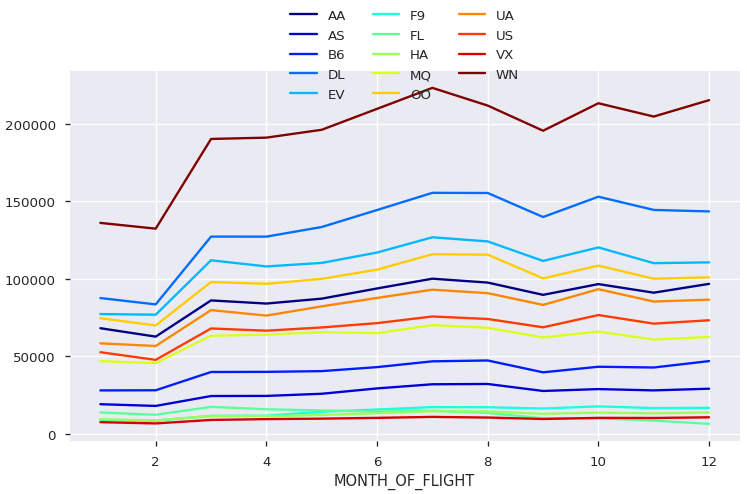

In [163]:
display(monthlyFlightsTrendPerCarrier)

In [144]:
from pyspark.sql import Window
from pyspark.sql.functions import min,max,avg
monthlyFlightsTrendPerCarrier=monthlyFlightsTrendPerCarrier\
.withColumn('PREV_MONTH_TREND',\
            lag(col("MONTHLY_FLIGHTS_TREND"),count=1)\
            .over(Window.partitionBy("UNIQUE_CARRIER")\
                  .orderBy("MONTH_OF_FLIGHT")))


monthlyFlightsTrendPerCarrier=monthlyFlightsTrendPerCarrier\
.filter(col('PREV_MONTH_TREND').isNotNull())\
.withColumn("MONTHLY_FLIGHT_TREND_PERC_CHANGE",\
            (col("MONTHLY_FLIGHTS_TREND")-col("PREV_MONTH_TREND"))/col('PREV_MONTH_TREND')*lit(100))\
.groupBy("UNIQUE_CARRIER").agg(
    avg(col("MONTHLY_FLIGHT_TREND_PERC_CHANGE")).alias("MONTHLY_FLIGHT_TREND_PERC_CHANGE_AVERAGE"),
    min(col("MONTHLY_FLIGHT_TREND_PERC_CHANGE")).alias("MONTHLY_FLIGHT_TREND_PERC_CHANGE_MIN"),
    max(col("MONTHLY_FLIGHT_TREND_PERC_CHANGE")).alias("MONTHLY_FLIGHT_TREND_PERC_CHANGE_MAX")
)

monthlyFlightsTrendPerCarrier.show()


+--------------+----------------------------------------+------------------------------------+------------------------------------+
|UNIQUE_CARRIER|MONTHLY_FLIGHT_TREND_PERC_CHANGE_AVERAGE|MONTHLY_FLIGHT_TREND_PERC_CHANGE_MIN|MONTHLY_FLIGHT_TREND_PERC_CHANGE_MAX|
+--------------+----------------------------------------+------------------------------------+------------------------------------+
|            UA|                       4.392513663914176|                   -8.55367473751875|                   40.90507960040947|
|            AA|                       3.875494059542005|                  -8.120236046225719|                   37.27516264829698|
|            EV|                       4.164306312688837|                 -10.157646414711518|                   45.72231473771857|
|            B6|                       5.590055472783892|                 -16.179081762069842|                   42.02051866628669|
|            DL|                       5.597853155825036|                   

In [145]:
from pyspark.sql.functions import count,sum,col,round,avg,lit

carrierLevelSummary=flight_DF.join(uniqueCarrierDF,flight_DF["UNIQUE_CARRIER"]==uniqueCarrierDF["Code"])\
        .drop("Code")\
        .groupBy(["UNIQUE_CARRIER","CARRIER_NAME"])\
        .agg(count(col("FL_NUM")).alias("TOTAL_FLIGHTS"),
             sum(col("CANCELLED")).alias("CANCELLED_FLIGHTS"),
             sum(col("DIVERTED")).alias("DIVERTED_FLIGHTS"),
             round(avg(col("DEP_DELAY_NEW")+col("ARR_DELAY_NEW")),2).alias("AVERAGE_DELAY"),
             round(avg(col("DISTANCE")),2).alias("AVERAGE_DISTANCE")
            )\
        .withColumn("CANCELLED_FLIGHTS_PERC",round(col("CANCELLED_FLIGHTS")/col("TOTAL_FLIGHTS")*100,2))\
        .withColumn("DIVERTED_FLIGHTS_PERC",round(col("DIVERTED_FLIGHTS")/col("TOTAL_FLIGHTS")*100,2))\
        .drop("CANCELLED_FLIGHTS").drop("DIVERTED_FLIGHTS")\
        .join(monthlyFlightsTrendPerCarrier,["UNIQUE_CARRIER"])



In [146]:
display(carrierLevelSummary)

UNIQUE_CARRIER,CARRIER_NAME,TOTAL_FLIGHTS,AVERAGE_DELAY,AVERAGE_DISTANCE,CANCELLED_FLIGHTS_PERC,DIVERTED_FLIGHTS_PERC,MONTHLY_FLIGHT_TREND_PERC_CHANGE_AVERAGE,MONTHLY_FLIGHT_TREND_PERC_CHANGE_MIN,MONTHLY_FLIGHT_TREND_PERC_CHANGE_MAX
FL,AirTran Airways Corporation (1994 - 2014)--Frontier Airlines Inc. (1960 - 1986),79495,20.19,683.91,1.91,0.2,-5.371585261662822,-25.424739195231,41.60679294578707
US,USAir (1988 - 1997)--US Airways Inc. (1997 - 2015),414665,18.26,888.87,1.62,0.18,3.8330533846585606,-9.423069619051235,42.51509560550151
F9,Frontier Airlines Inc. (1994 - ),85474,32.12,855.92,0.42,0.17,6.558000875119098,-6.137470275167025,36.88582957512461
WN,Southwest Airlines Co. (1979 - ),1174633,30.74,715.71,1.29,0.23,4.989517481333906,-7.660361686865255,43.73348233837232
MQ,Envoy Air (2014 - )--Simmons Airlines (1991 - 1998)--American Eagle Airlines Inc. (1998 - 2014),392701,30.41,460.27,5.39,0.26,3.2929720942537815,-9.20007011803202,38.94547370269558
OO,SkyWest Airlines Inc. (2003 - ),613030,25.76,471.98,2.99,0.27,3.5608468930344697,-13.264847289958839,40.137883685670964
DL,Delta Air Lines Inc. (1960 - ),800375,19.42,872.03,0.81,0.17,5.597853155825036,-9.97941592692654,52.40284462323109
B6,JetBlue Airways (2000 - ),249693,27.84,1057.91,2.43,0.28,5.590055472783892,-16.179081762069842,42.02051866628669
AS,Alaska Airlines Inc. (1960 - ),160257,13.91,1183.55,0.47,0.28,4.556278340172046,-14.072322150992719,35.61643835616438
VX,Virgin America (2007 - )--Aces Airlines (1992 - 2003),57510,25.14,1462.71,0.58,0.21,3.8156895060160094,-10.950468540829988,34.03487672880337


In [148]:
carrierLevelSummaryPandas=carrierLevelSummary.toPandas()
carrierLevelSummaryPandas.corr()

,TOTAL_FLIGHTS,AVERAGE_DELAY,AVERAGE_DISTANCE,CANCELLED_FLIGHTS_PERC,DIVERTED_FLIGHTS_PERC,MONTHLY_FLIGHT_TREND_PERC_CHANGE_AVERAGE,MONTHLY_FLIGHT_TREND_PERC_CHANGE_MIN,MONTHLY_FLIGHT_TREND_PERC_CHANGE_MAX
TOTAL_FLIGHTS,1.000000,0.397169,-0.287445,0.263291,0.286985,0.274145,0.391966,0.676782
AVERAGE_DELAY,0.397169,1.000000,-0.060174,0.536052,0.548767,0.200017,0.344041,0.258899
AVERAGE_DISTANCE,-0.287445,-0.060174,1.000000,-0.576727,0.092138,0.209396,0.087684,-0.245452
CANCELLED_FLIGHTS_PERC,0.263291,0.536052,-0.576727,1.000000,0.509154,-0.149680,-0.048095,0.285575
DIVERTED_FLIGHTS_PERC,0.286985,0.548767,0.092138,0.509154,1.000000,0.043659,0.012542,0.071334
MONTHLY_FLIGHT_TREND_PERC_CHANGE_AVERAGE,0.274145,0.200017,0.209396,-0.149680,0.043659,1.000000,0.807950,0.023068
MONTHLY_FLIGHT_TREND_PERC_CHANGE_MIN,0.391966,0.344041,0.087684,-0.048095,0.012542,0.807950,1.000000,-0.020418
MONTHLY_FLIGHT_TREND_PERC_CHANGE_MAX,0.676782,0.258899,-0.245452,0.285575,0.071334,0.023068,-0.020418,1.000000


In [149]:
carrierLevelSummaryPandas.to_excel("outputs/carrier_level_summary.xlsx")

In [6]:
spark.stop()